# Imports

In [6]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np
from models import Actor, Critic#, Memory
from plotting import plot_epoch
from enviroment import force, update_state, reward, goal_check
from torch.profiler import profile, ProfilerActivity
import time


device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
tr.autograd.set_detect_anomaly(True)
tr.set_default_tensor_type(tr.FloatTensor)

# Settings

In [7]:
# ---------------- Training -------------------
runs = 1
max_episodes = 10
max_steps = 300
batch_size = 512
target_model_update = 2
gamma_discount = 0.8
learning_rate = 0.01
learning_rate_decay = 0.5

# ---------------- Environment  ----------------
# Time step size
dt = 0.04
# Target position
target = [0.5,0]
target_deviation = 0.01
target_area = [[target[0]-target_deviation,target[0]+target_deviation],
               [target[1]-target_deviation,target[1]+target_deviation]]
char_length = 2
# Maximum of potential
U0 = 0.4

# ---------------- Agent ----------------------
lstm_hidden_size = 0
hidden_dims = 32

# ---------------- Other ----------------------
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.dpi': 150})
total_time = []
update_state_time = []

# Training

### Episode

In [8]:
def train_episode(actor,critic,target_actor,target_critic, x_initial, y_initial, optimizer):
    
    F_x_initial, F_y_inital = force(x_initial,y_initial, U0)
    theta_initial = tr.zeros(batch_size).to(device)
    state = tr.stack((x_initial,y_initial,F_x_initial,F_y_inital,theta_initial),dim=1)

    #Initialize Replay Buffer
    # memory = Memory(max_size = 50)
    states = [state]
    actions = []
    losses = []
    success_batch_index = None
    # Perform Episode
    for step in range(max_steps):
        time_start = time.time()

        optimizer.zero_grad()

        if step%target_model_update == 0:
            target_actor.load_state_dict(actor.state_dict())
            target_critic.load_state_dict(critic.state_dict())

        
        action_now = actor.forward(state)
        actions.append(action_now[0].item())

        Q_now = critic.forward(state, action_now)
        new_state, wall_bool = update_state(state,action_now,dt,U0,batch_size,char_length)

        target_bool = goal_check(state,target_area)
        Reward = reward(new_state,dt, target_bool, wall_bool)
        
        action_future = target_actor(new_state)
        Q_future = target_critic(new_state, action_future)
        # memory.push(
        target = Reward[:,None] + gamma_discount*Q_future
        criterion = nn.MSELoss()
        target = target.detach()
        
        #Compute Gradients
        time_state_start = time.time() 

        loss = criterion(target, Q_now)
        losses.append(loss)
        loss.backward()

        optimizer.step()
        
        state = new_state
        #Detach Variables
        state = state.detach()
        Reward = Reward.detach()
        states.append(state)

        update_state_time.append(time.time()-time_state_start)

        #NO BREAK IF TARGET IS REACHED!
        if target_bool.max().item() > 0: 
            success_batch_index = tr.argmax(target_bool.int()).item()
            # print('Goal Reached!')
        total_time.append(time.time()-time_start)
        

    if success_batch_index is None: success_batch_index = 0
    states = tr.stack(states)
    # losses =  np.array(losses).mean()
    return states, success_batch_index, actions


### Simulation

In [9]:
def train_simulation(hidden_dims):
    #Initialize Agent-Critic Networks
    actor = Actor(hidden_dims).to(device)
    target_actor = Actor(hidden_dims).to(device)

    critic = Critic(hidden_dims).to(device)
    target_critic = Critic(hidden_dims).to(device)
    
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    #Optimizer
    params = list(actor.parameters()) + list(critic.parameters())
    optimizer = tr.optim.Adam(params, lr=learning_rate)

    #Scheduler
    milestones = np.linspace(max_episodes//5,max_episodes,5)
    scheduler = MultiStepLR(optimizer, milestones, gamma = learning_rate_decay)

    #Store Paths
    x_paths, y_paths = [], []
    total_mean_losses = []
    #Perform a Run
    for i in range(max_episodes):
        #initialize in random positions:
        x_initial = tr.empty(batch_size).to(device).uniform_(-0.75,0.75)
        y_initial = tr.empty(batch_size).to(device).uniform_(-0.75,0.75)
        
        states, success_batch_index, actions = train_episode(actor, critic, target_actor, target_critic, x_initial, y_initial, optimizer)
        # sucess_batch_indexes.append(success_batch_index)
        if i%(max_episodes//5) == max_episodes//5-1:
            print(f'Episode {i}: Mean = {np.round(np.mean(actions),2)}, std = {np.round(np.std(actions),2)}')
            x_path = states[:,:, 0]
            y_path = states[:,:, 1]
            x = x_path[:,success_batch_index].detach().to('cpu').numpy()
            y = y_path[:,success_batch_index].detach().to('cpu').numpy()
            x_paths.append(x)
            y_paths.append(y)
            scheduler.step()
        # total_mean_losses.append(losses)
    return actor,x_paths, y_paths


In [10]:
actor, x_paths, y_paths = train_simulation(hidden_dims)
print(f'Total Step Time: {np.round(np.mean(total_time),5)}, Update State Time: {np.round(np.mean(update_state_time),5)}, Ratio: {np.round(np.mean(update_state_time)/np.mean(total_time),5)}')

Episode 1: Mean = 2.77, std = 1.63
Episode 3: Mean = 2.36, std = 1.22
Episode 5: Mean = 2.86, std = 0.17
Episode 7: Mean = 2.49, std = 0.43
Episode 9: Mean = 2.58, std = 0.33
Total Step Time: 0.06503, Update State Time: 0.00802, Ratio: 0.12335


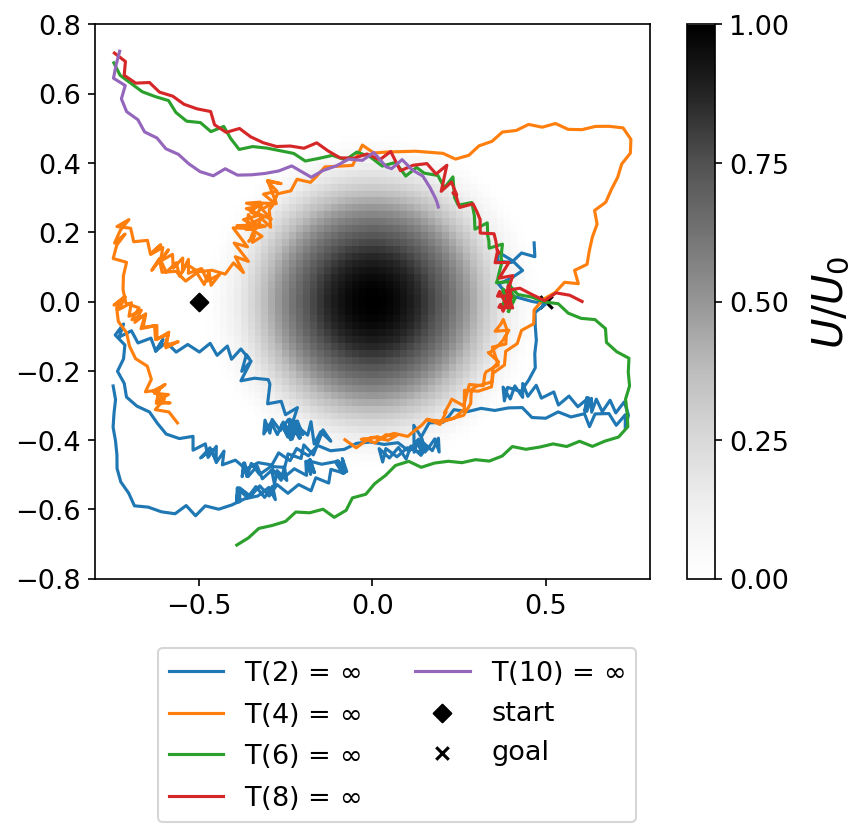

In [11]:
plot_epoch(x_paths, y_paths, max_steps, max_episodes, dt, U0) 

In [12]:
# X = np.linspace(0,max_episodes,max_episodes)
# plt.plot(X,total_mean_losses)

# Testing

### Episode

In [13]:
def test_episode(actor):
    # Initialize State
    x_initial = -0.5*tr.ones(batch_size).to(device)
    y_initial = tr.zeros(batch_size).to(device)
    
    F_x_initial, F_y_inital = force(x_initial,y_initial, U0)
    theta_initial = tr.zeros(batch_size).to(device)
    state = tr.stack((x_initial,y_initial,F_x_initial,F_y_inital,theta_initial),dim=1)

    #Initialize Replay Buffer
    # memory = Memory(max_size = 50)
    states = [state]
    actions = []
    success_batch_index = None
    # Perform Episode
    for step in range(max_steps):
        action = actor.forward(state)
        actions.append(action[0].item())

        new_state, _ = update_state(state, action, dt, U0, batch_size, char_length)
        state = new_state
        states.append(state)
        target_bool = goal_check(state,target_area)
        if target_bool.max().item() > 0: 
            success_batch_index = tr.argmax(target_bool.int()).item()
            break

    if success_batch_index is None: success_batch_index = 0
    states = tr.stack(states)
    return states, success_batch_index, actions


### Simulation

In [14]:
def test_simulation(actor):
    actor.eval()
    #Store Paths
    x_paths, y_paths = [], []
    
    # #Perform a Run
    for i in range(5):
        with tr.no_grad():
            states, success_batch_index, episode_action = test_episode(actor)
        # sucess_batch_indexes.append(success_batch_index)

        x_path = states[:,:, 0]
        y_path = states[:,:, 1]
        x = x_path[:,success_batch_index].detach().to('cpu').numpy()
        y = y_path[:,success_batch_index].detach().to('cpu').numpy()
        x_paths.append(x)
        y_paths.append(y)
    return x_paths, y_paths


In [15]:
x_paths, y_paths = test_simulation(actor)

## Plotting

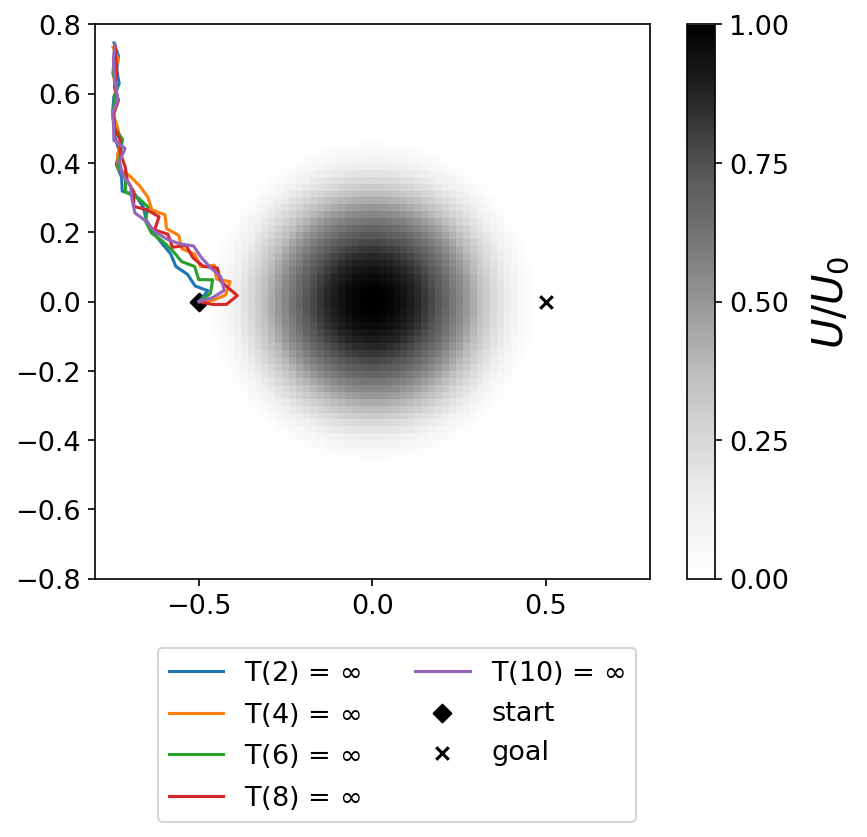

In [16]:
plot_epoch(x_paths, y_paths, max_steps, max_episodes, dt, U0)   